In [1]:
import yt
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from matplotlib import colormaps
import scipy as sp
import pandas as pd
import os
import glob
from astropy.cosmology import FlatLambdaCDM
import pickle
import trident
import h5py
from trident.absorption_spectrum.absorption_spectrum_fit import generate_total_fit
from Codes.fitting import fitting
yt.set_log_level(50)

In [2]:
def read_info(RamsesDir, timestep, alt_path=None):
    """ Returns info from the simulation (dict). """
    #savepath = get_alt_path(RamsesDir, alt_path=alt_path)
    #check_ratapath(savepath)
    savepath = RamsesDir
    path_info = f'{savepath}/ratadat/info_dict.pkl'
    if not os.path.exists(path_info):                # If first time, save general data
        info_dict = read_info_glob(RamsesDir, timestep=timestep)
        with open(path_info, 'wb') as file: 
            pickle.dump({'00000': info_dict}, file)
    with open(path_info, 'rb') as file:              # Otherwise, load common data
        all_info = pickle.load(file)
        info_dict = all_info.get('00000', {}).copy() # Important to copy, otherwise '00000' will be modified
        if timestep != 0:
            t_group = f'{timestep:05d}'
            if t_group in all_info:                  # And add timestep specific data.
                info_dict = all_info[t_group]
            else:
                info_dict = read_info_tstep(RamsesDir, timestep, info_dict)
                all_info[t_group] = info_dict
                with open(path_info, 'wb') as file:
                    pickle.dump(all_info, file)
    return info_dict


def read_info_glob(RamsesDir, timestep=1):
    """ Read info parameters common to all timesteps of a given simulation. """
    tstep = f'{timestep:05d}'
    path_out = f'{RamsesDir}/output_{tstep}/'
    
    # Initialise some variables which might not be defined.
    info_dict = {}
    info_dict['new_format'] = get_format(f'{path_out}header_{tstep}.txt')                     # Get whether post-2017 or not
    for key in ['isH2', 'delayed_cooling', 'momentum_feedback']:
        info_dict[key] = False

    # Namelist
    info_dict  = param2dict(info_dict, get_nml(RamsesDir, timestep))                                    # Namelist
    info_dict  = param2dict(info_dict, f'{path_out}info_rt_{tstep}.txt')                                # info_rt_xxxxx.txt
    info_dict  = hydro2dict(info_dict, f'{path_out}hydro_file_descriptor.txt', info_dict['new_format']) # hydro_file_descriptor
    info_dict  = get_nvar  (info_dict, path_out, tstep)                                                 # (after hydro2dict)

    # Corrections
    info_dict['X_fraction'] = round(info_dict['X_fraction'], 6) # Correct precision error in info_rt_xxxxx.txt
    info_dict['Y_fraction'] = round(info_dict['Y_fraction'], 6)

    # Determine simulation type
    # Note: original way is the following BUT have to read info_xxxxx.txt (resp header_xxx.txt), and some variables there depends on timestep
    #       info_dict['is_cosmo'] = info_dict['omega_m']!=1.0 and info_dict['aexp']!=1 and info_dict['H0']!=1 
    #       info_dict['is_zoom']  = info_dict['is_cosmo'] and info_dict['ndm'] != (2*info_dict['levelmin'])*info_dict['ndim']
    info_dict['is_cosmo'] = info_dict['cosmo']
    info_dict['is_zoom']  = info_dict['is_cosmo'] and 'initfile(2)' in info_dict
    info_dict['is_cool_refine'] = 'cooling_refine' in info_dict and any(value != -1 for value in info_dict['cooling_refine'])
    info_dict['nvarnoadvect'] = info_dict['cooling_time_ivar'] if info_dict['is_cool_refine'] else 0

    return info_dict


def read_info_tstep(RamsesDir, timestep, info_dict):
    """ Read info parameters for a given timestep anc add some units. """
    tstep = f'{timestep:05d}'
    path_out = f'{RamsesDir}/output_{tstep}/'
    info_dict  = param2dict(info_dict, f'{path_out}info_{tstep}.txt')               # info_xxxxx.txt
    info_dict  = headr2dict(info_dict, f'{path_out}header_{tstep}.txt', info_dict['new_format']) # header_xxxxx.txt

    # Units
    info_dict['unit_m']      = info_dict['unit_d']*info_dict['unit_l']**3
    info_dict['unit_v']      = info_dict['unit_l']/info_dict['unit_t']
    info_dict['unit_P']      = info_dict['unit_d']*info_dict['unit_v']**2
    info_dict['unit_T2']     = mH/kB*info_dict['unit_v']**2
    info_dict['unit_nH']     = info_dict['X_fraction']*info_dict['unit_d']/mH
    info_dict['unit_nHe']    = info_dict['unit_nH'] * info_dict['Y_fraction']/info_dict['X_fraction'] * 0.25
    info_dict['cu2cm']       = info_dict['unit_l'] * info_dict['boxlen']
    info_dict['boxlen_cMpc'] = info_dict['boxlen']*info_dict['unit_l']/info_dict['aexp']/kpc2cm/1e3 if info_dict['is_cosmo'] else None
    info_dict['redshift']    = 1./info_dict['aexp']-1
    info_dict['t_myr']       = info_dict['time']*info_dict['unit_t']/Myr2s if not info_dict['is_cosmo']\
        else FlatLambdaCDM(H0=info_dict['H0'],Om0=info_dict['omega_m']).age(1/info_dict['aexp']-1).value*1e3
    return info_dict


def get_nml(RamsesDir, timestep):
    """Return the path to the nml."""
    # Check the output directory
    path_nml = f'{RamsesDir}/output_{timestep:05d}/namelist.txt'    
    if os.access(path_nml, os.R_OK):            # Check it's readable
        with open(path_nml, 'r') as file:
            for line in file:
                if '&RUN_PARAMS' in line:       
                    return path_nml
    # If the file is doesn't exist/is corrupted, check the RamsesDir
    nml_files = glob.glob(f"{RamsesDir}/*.nml")
    path_nml = next((f for f in nml_files if os.access(f, os.R_OK)), None) # First nml with read access
    if path_nml is None:
        raise Exception(f"No accessible .nml file found in {RamsesDir}.")
    return path_nml


def headr2dict(info_dict, file_path, new_format):
    """ Add header variables (i.e. number of particles and particle fields) to info_dict. """
    header = {
        "Total number of particles": "npart",       # Old format
        "Total number of dark matter particles": "ndm",
        "Total number of star particles": "nstar",
        "Total number of sink particles": "nsink",
        "DM": "ndm",                                # New format
        "star": "nstar",
    }
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if "Particle fields" in line:
                info_dict["particle_fields"] = next(file).strip().split()
                break  # No more info after particle fields
            parts = line.split()
            if new_format and len(parts) == 2 and parts[0] in header:
                info_dict[header[parts[0]]] = int(parts[1])
            elif not new_format and 'Total' in line:
                info_dict[header[line]] = int(next(file).strip())
    return info_dict


def hydro2dict(info_dict, path_hydrofd, new_format):
    """ Read hydro_file_descriptor and add the indexes of the hydro parameters to info_dict. """
    with open(path_hydrofd, 'r') as file:
        for line in file:
            line = line.strip()
            if not line.startswith('#'): # skip the first in new format
                parts = line.split(',') if new_format else line.replace('#', ':').split(':')
                index1, index2 = (0, 1) if new_format else (-2, -1)
                if len(parts) >= 2:
                    info_dict[parts[index2].strip()] = int(parts[index1].strip())
    rename_map = {
        'density': 'idens',
        'velocity_x': 'ivel',
        'thermal_pressure': 'iPT',
        'pressure': 'iPT'
    }
    for old_name, new_name in rename_map.items():
        if old_name in info_dict:
            info_dict[new_name] = info_dict.pop(old_name)
    return info_dict


def get_nvar(info_dict, path_out, tstep):
    """ Try to get nvar from hydro_xxxxx.out00001, and in the hydro_file_descriptor if it fails. 
        First option is favoured as the hydro_file_descriptor can be badly coded. """
    hydro_file = f'{path_out}hydro_{tstep}.out00001'
    if os.path.exists(hydro_file):          # Try to read hydro_xxxxx.out00001
        with open(f'{path_out}hydro_{tstep}.out00001', 'rb') as f:  
            info_dict['nvar'] = np.fromfile(f, dtype=np.int32, count=5)[4]
    elif not 'dm' in path_out.lower():      # Else, skip if DM-only simulation and take the highest value from the hydro_file_descriptor.
        info_dict['nvar'] = info_dict[max((key for key in info_dict if 'scalar_' in key), key=lambda x: int(x.rsplit('_', 1)[1]), default=None)]
    return info_dict
def get_ramses_index(info, include_rt=False):                                                         # TODO: CR, MHD
    """ 
    Determine the index of the variables in the ramses output.
    """
    # Variables obtained in info
    dict_index = {'Density':       info['idens'],
                  'x-velocity':       info['ivel'],
                  'y-velocity':       info['ivel']+1                    if info['ndim']>=2 else None,
                  'z-velocity':       info['ivel']+2                    if info['ndim']>=3 else None,
                  'Pressure':        info['iPT']+info['rt_isIRtrap'],
                  'Metallicity':        info['iPT']+info['rt_isIRtrap']+1 if info['metal']   else None,
                  'xHI':      info['iIons']                     if info['isH2']    else None,
                  'xHII':     info['iIons']+info['isH2']        if info['rt']      else None,
                  'xHeII':    info['iIons']+info['isH2']+1      if info['rt']      else None,
                  'xHeIII':   info['iIons']+info['isH2']+2      if info['rt']      else None,
                }

    # Additional variables
    counter = info['iPT'] + info['rt_isIRtrap'] + info['metal'] + info['nIons']  # info['isH2'] already counted in nIons
    if info['delayed_cooling']:   dict_index['DC_var'],         counter = counter + 1, counter + 1  # delayed cooling
    if info['momentum_feedback']: dict_index['KR_turb'],        counter = counter + 1, counter + 1  # patch mom2 by Kretschmer
    if info['is_zoom']:           dict_index['zoom_var'],       counter = counter + 1, counter + 1  # zoom-in simulations
    if info['is_cool_refine']:    dict_index['cooling_length'], counter = counter + 1, counter + 1  # cooling length refinement

    # RT variables: N_photons and flux_nx/y/z for each group n.
    if info['rt'] and include_rt:
        for i in range(1, info['nGroups'] + 1):
            dict_index[f'N_photons{i}'] = info['nvar'] + 1 + (i - 1) * 4 if info['nGroups'] >= i else None
            for axis in ['x', 'y', 'z']:
                dict_index[f'flux_{i}{axis}'] = info['nvar'] + 2 + "xyz".index(axis) + (i - 1) * 4 if info['nGroups'] >= i else None

    return dict_index

def get_values(var, dictionary):    # TODO: restrict to one value, not T or temperature. Then, remove this function -> everything will be more readable.
    """ Helper function to be able to format dictionary keys as tuples. """
    for key in dictionary:
        if var in key:
            return dictionary[key]
    return None


def get_format(path_hdr):
    """ Returns whether the code is formatted following RAMSES post-2017 or not. """
    with open(path_hdr, 'r') as file:
        first_line = file.readline().strip()
        if 'Total number of particles' in first_line: return False
        elif '#      Family     Count' in first_line: return True
        else: raise ValueError("Unrecognized header format.")


def fort2py(value):
    """ Convert Fortran values to Python. """
    if value.lower() in ('.true.', '.false.'):  return value.lower() == '.true.'    # Booleans
    elif (value.startswith("'") and value.endswith("'")): return value[1:-1]        # Strings
    else:
        try: return float(value) if 'e' in value or '.' in value else int(value)    # Numerals
        except ValueError:  return value                                            # Other strings


def param2dict(info_dict, path_file):
    """ General function to get parameters from a file and add them to a dictionary. """
    with open(path_file, 'r') as file:
        for line in file:
            line = line.split('!')[0].strip()       # Remove comments and whitespace
            if '=' in line:
                key, value = map(str.strip, line.split('='))
                if key!='movie_vars_txt':           # Replace 'd' with 'e' for float compatibility
                    value = value.replace('d', 'e')
                if ',' in value or '*' in value:    # Convert lists
                    value_list = []
                    for element in value.split(','):
                        if '*' in element:
                            count, val = element.split('*')
                            value_list.extend([int(float(val.strip()))] * int(count))
                        else:
                            value_list.append(fort2py(element.strip()))
                    value = value_list
                else:
                    value = fort2py(value)          # Convert single values
                info_dict[key] = value
            elif "DOMAIN" in line or "Photon group properties" in line:
                break
    return info_dict

In [3]:
RamsesDir = '/minkewhale/kimm/rey/G8_normal/GTT_9pc'
timestep = 203

info = read_info(RamsesDir, 203)
dict_index = get_ramses_index(info)
print(info['t_myr'])
print(dict_index)

extra_particle_fields = [("particle_birth_time", "float64"), ("particle_metallicity", "float64"), ("particle_imass", "float64")]
    #extra fields included in the data that yt does not automatically detect (I assume to save time?)
center_dat=[0.5, 0.5, 0.5]
rad_dat = 0.2739726724728318
bbox = [[c-rad_dat for c in center_dat], [c+rad_dat for c in center_dat]]
ds = yt.load(f'{RamsesDir}/output_{timestep:05d}', extra_particle_fields=extra_particle_fields, fields = list(dict_index.keys()), bbox = bbox)
#ad = ds.all_data() #apparently required to put all data into a readable way.
#reg = ds.r[(-41.0959, "kpc"):(41.0959, "kpc"), (-41.0959, "kpc"):(41.0959, "kpc"), (-41.0959, "kpc"):(41.0959, "kpc")]


504.68349268563725
{'Density': 1, 'x-velocity': 2, 'y-velocity': 3, 'z-velocity': 4, 'Pressure': 5, 'Metallicity': 6, 'xHI': 7, 'xHII': 8, 'xHeII': 9, 'xHeIII': 10}


In [4]:
_rho = 3e-25
_Temp = 1e4
_vel_r = 7000*1000

def _radius(field, data):
    x = np.array(data['gas', 'x'].in_units('kpc').value)-75
    y = np.array(data['gas', 'y'].in_units('kpc').value)-75
    z = np.array(data['gas', 'z'].in_units('kpc').value)-75
    rv = np.sqrt(x**2 + y**2 + z**2)
    # print(rv)
    return yt.YTArray(rv, 'kpc')
ds.add_field(
    ("gas", "radius"),
    sampling_type="cell",
    function=_radius,
    units='kpc',
    force_override = True
)

def _theta(field, data):
    x = np.array(data['gas', 'x'].in_units('kpc').value)-75
    y = np.array(data['gas', 'y'].in_units('kpc').value)-75
    z = np.array(data['gas', 'z'].in_units('kpc').value)-75
    r = np.sqrt(x**2 + y**2)
    rv = np.arctan2(r, z)
    return yt.YTArray(rv, 'kpc')
ds.add_field(
    ("gas", "theta"),
    sampling_type="cell",
    function=_theta,
    units='kpc',
    force_override = True
)


def _temperature_mu_2(field, data):
    theta = data['gas', 'theta']
    r = data['gas', 'radius'].in_units('kpc')
    rv = []
    mask = ((theta > 2.44) | (theta < 0.698)) & ((r < 35))
    rv = np.where(mask, _Temp, 1e6)
    return yt.YTArray(rv, 'K')

ds.add_field(
    ("gas", "temperature_mu"),
    sampling_type="cell",
    function=_temperature_mu_2,
    units='K',
    force_override = True
)

print(ds.all_data()[('gas', 'temperature_mu')])


def _density_2(field, data):
    theta = data['gas', 'theta']
    r = data['gas', 'radius'].in_units('kpc')
    rv = data['gas', 'density'].in_units('g/cm**3').value
    den_ori = rv.copy()
    def den(r):
        return _rho
    mask = ((theta > 2.44) | (theta < 0.698)) & ((r < 35))
    rv = np.where(mask, den(r), 1e-29)
    return yt.YTArray(rv, 'g/cm**3')

ds.add_field(
    ("gas", "density_2"),
    sampling_type="cell",
    function=_density_2,
    units='g/cm**3',
    force_override = True
)



def _vel(field, data):
    theta = data['gas', 'theta']
    r = data['gas', 'radius'].in_units('kpc')
    rv = data['gas', 'radial_velocity'].in_units('cm/s').value
    v_rad = _vel_r
    T = data[('gas', 'temperature_mu')]
    if len(np.shape(theta)) == 1:
        mask = ((theta > 2.44) | (theta < 0.698)) & ((r < 35))
        rv = np.where(mask, _vel_r, 0)
    return yt.YTArray(rv, 'cm/s')

ds.add_field(
    ("gas", "vel_rad"),
    sampling_type="cell",
    function=_vel,
    units='cm/s',
    force_override = True
)


[1000000. 1000000. 1000000. ... 1000000. 1000000. 1000000.] K


[  0.  22. -75.] [ 0. 22. 75.]
128


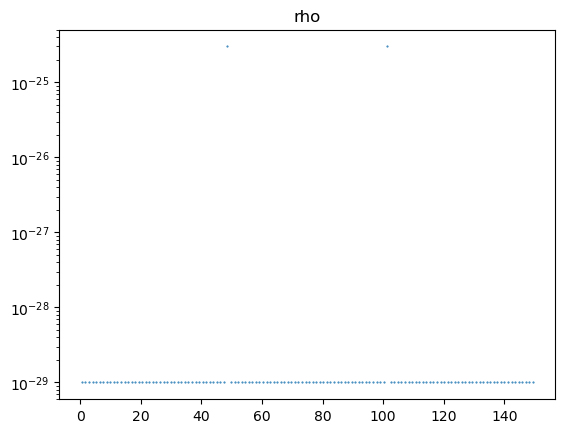

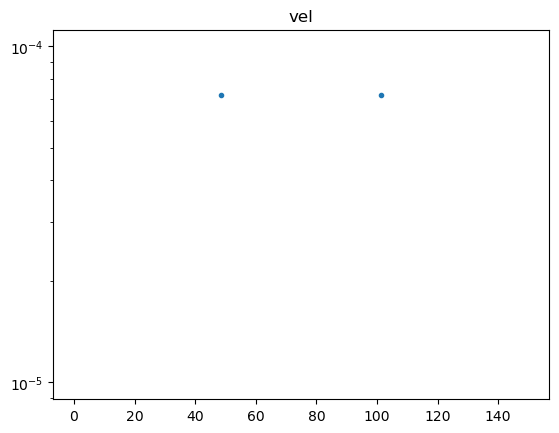

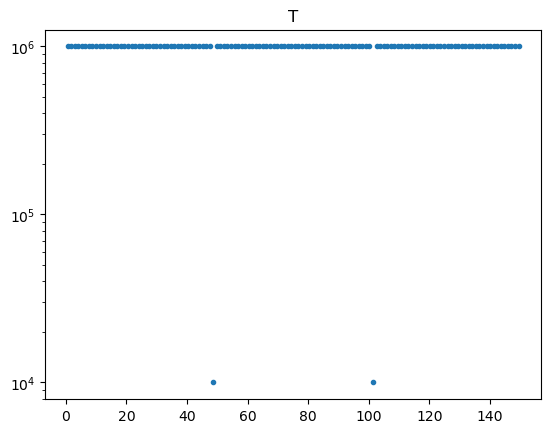

In [56]:
def sort_by_sight_line(t, dat):
    Big_list = np.array([t, dat])
    return(Big_list[:, Big_list[0].argsort()][1])


def to_kpc(cl):
    return cl/(3.08567758128E+21/(0.150000000000000E+03*0.308567758128200E+22)) #have to change accordingly with the specific file


start, end = np.array([0.5, to_cl(97), 0]), np.array([0.5, to_cl(97), 1])
print(to_kpc(start)-75, to_kpc(end)-75)

# ad = ds.r[start:end]

ad = ds.ray(start,end)
# print(ad['t'])
# print(help(ad))
# ad = ray.all_data()

rho_p = ad[('gas', 'density_2')].in_units('g/cm**3')
T_p = ad[('gas', 'temperature_mu')].in_units('K')
theta_p = ad[('index', 'spherical_theta')]
vel_rad_p = ad[('gas', 'vel_rad')].in_units('pc/yr')
dx_p = ad[('gas', 'dx')].in_units('pc')
dy_p = ad[('gas', 'dy')].in_units('pc')
z_p = ad[('gas', 'z')].in_units('kpc')
x_p = ad[('gas', 'x')].in_units('kpc')
r_p = ad[('index', 'spherical_radius')].in_units('kpc')

ray_sort = np.argsort(ad["t"])
density = ad[("gas", "density_2")][ray_sort]
ray_sort = np.argsort(ad["t"])
z = ad[("gas", "z")][ray_sort].in_units('kpc')



np.set_printoptions(suppress=True)
# print(np.array(theta))

# rho = sort_by_sight_line(ad['t'], rho_p)
# T = sort_by_sight_line(ad['t'], T_p)
# theta = (sort_by_sight_line(ad['t'], theta_p))
# vel_rad = sort_by_sight_line(ad['t'], vel_rad_p)
# dx = sort_by_sight_line(ad['t'], dx_p)
# dy = sort_by_sight_line(ad['t'], dy_p)
# z = sort_by_sight_line(ad['t'], z_p)
# r = sort_by_sight_line(ad['t'], r_p)

# dA = dx*dy
# v_z = vel_rad*np.cos(theta)

# # print(x)
# print('ahhhhhhhhhhhhhh')
# print(rho*1e27)
print(len(z_p))
# print(rho_p*1e29)
plt.plot(z, density, '.', ms = 1)
plt.yscale('log')
plt.title('rho')
plt.show()
plt.plot(z_p, vel_rad_p, '.')
plt.yscale('log')
plt.title('vel')
plt.show()
plt.plot(z_p, T_p, '.')
plt.yscale('log')
plt.title('T')
plt.show()


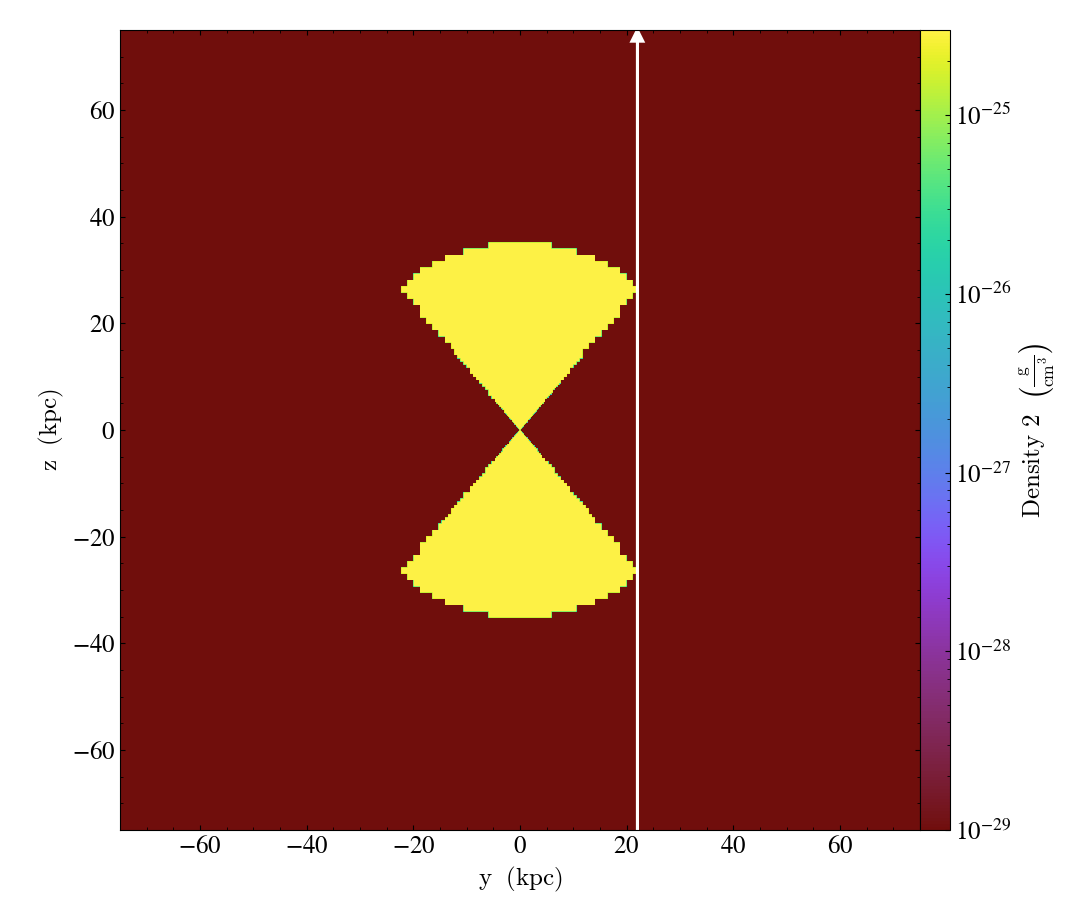

/home/chiyu/miniconda3/lib/python3.12/site-packages/unyt/array.py:1949: RuntimeWarning: invalid value encountered in divide
  out_arr = func(



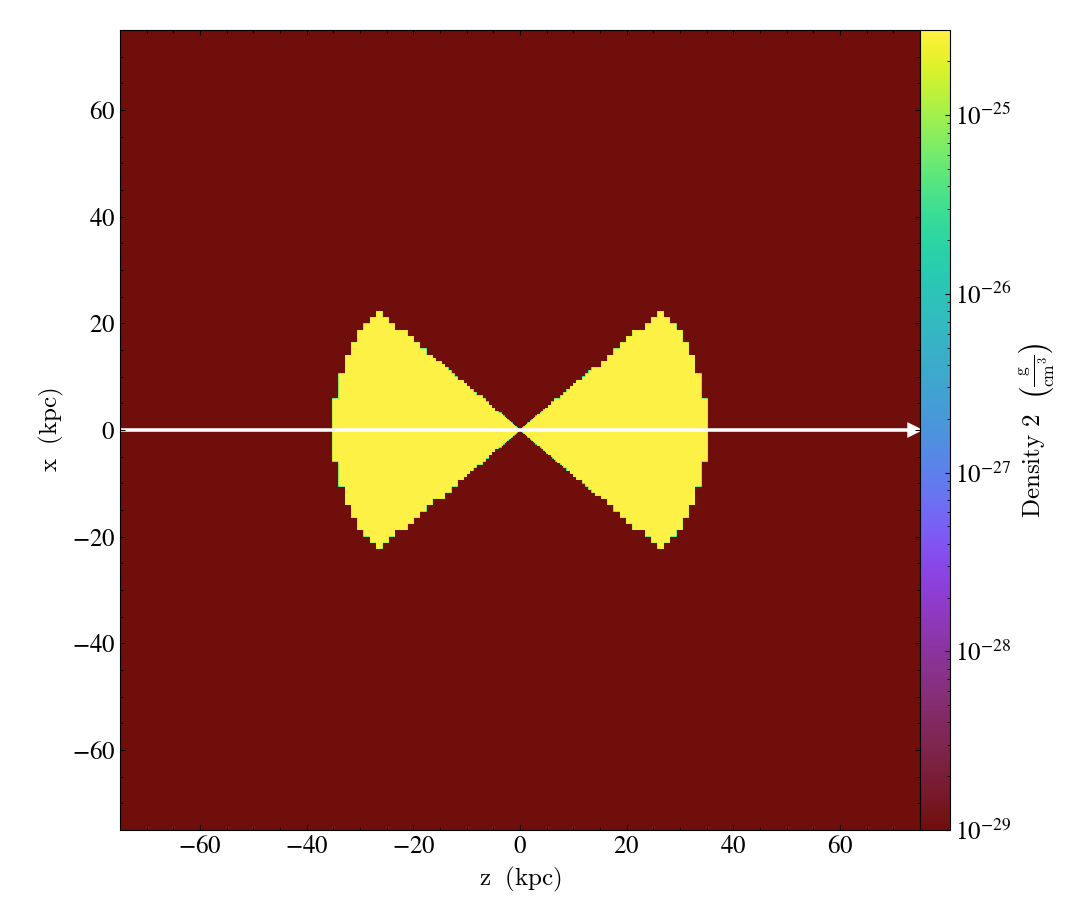

In [61]:
p = yt.SlicePlot(ds, 'x', ('gas', 'density_2'))
p.annotate_ray(ray, arrow=True)
p.zoom(1)
p.show()
p = yt.SlicePlot(ds, 'y', ('gas', 'density_2'))
p.annotate_ray(ray, arrow=True)
p.zoom(1)
p.show()

#   Makes the simple ray and specify the lines wanted

In [4]:
#This should add the ions estimates based on trident's integrated CLOUDY look up table
#Needs to be included in the line_list to be added to lines!!!!!!!

# trident.add_ion_fields(ds, ions=['O VI'])

trident.add_ion_fields(ds, ions=['H I'])

# trident.add_ion_fields(ds, ions=['C IV'])

# trident.add_ion_fields(ds, ions=['Si III'])
# trident.add_ion_fields(ds, ions=['Si IV'])


# trident.add_ion_fields(ds, ions=['N I'])
# trident.add_ion_fields(ds, ions=['N II'])
# trident.add_ion_fields(ds, ions=['N III'])
# trident.add_ion_fields(ds, ions=['N IV'])
# trident.add_ion_fields(ds, ions=['N V'])
# trident.add_ion_fields(ds, ions=['N VI'])

# trident.add_ion_fields(ds, ions=['Mg II'])

In [5]:
def to_cl(kpc):
    return kpc*3.08567758128E+21/(0.150000000000000E+03*0.308567758128200E+22) #have to change accordingly with the specific file

In [59]:
print(np.log10(ds.all_data()[('gas', 'temperature_mu')]).min())

4.0


In [11]:
#specifying what lines we want in our spectrum
line_list = ['H', 'C', 'N', 'O', 'Mg', 'Si']

#creating a LightRay object that saves to a file called ray.h5 (HDF 5 file)
#NOTE: I modified the left_edge to copy on the light_ray.py from trident (line 471)
# ray_start = start
# ray_end = end
ray_start, ray_end = [0.5, 0.5, 1], [0.5, 0.5, 0]
ray = trident.make_simple_ray(ds,
                              start_position=ray_start,
                              end_position=ray_end,
                              data_filename="ray.h5",
                              lines=line_list)
# ad = ray.all_data()

n = ray.all_data()[('gas', 'H_p0_number_density')].in_units('1/cm**3').value
dl = ray.all_data()[('gas', 'dl')].in_units('cm').value
# print(n*1e27)
print(np.sum(n*dl))


6.893666110258405e+21


In [16]:
sg = trident.SpectrumGenerator(bin_space = 'velocity') #can plot in terms of the velocity shift
sg.make_spectrum(ray, lines=line_list)

In [21]:
sg.plot_spectrum('Spectra')

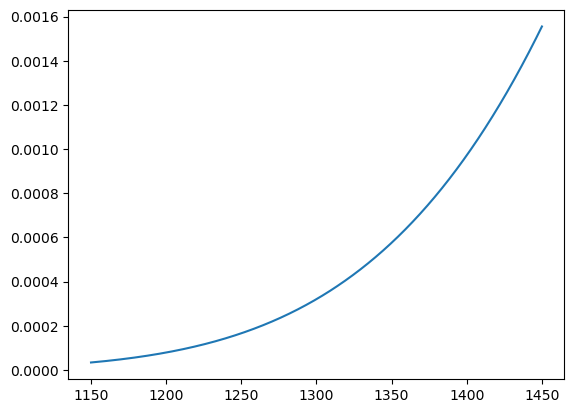

In [17]:
wavelength = np.array(sg.lambda_field.value)
flux = np.array(sg.flux_field)
plt.plot(wavelength, flux)

Plotting

In [9]:
ds.derived_field_list

[('all', 'age'),
 ('all', 'mesh_id'),
 ('all', 'particle_angular_momentum'),
 ('all', 'particle_angular_momentum_magnitude'),
 ('all', 'particle_angular_momentum_x'),
 ('all', 'particle_angular_momentum_y'),
 ('all', 'particle_angular_momentum_z'),
 ('all', 'particle_birth_time'),
 ('all', 'particle_identity'),
 ('all', 'particle_imass'),
 ('all', 'particle_index'),
 ('all', 'particle_mass'),
 ('all', 'particle_metallicity'),
 ('all', 'particle_ones'),
 ('all', 'particle_position'),
 ('all', 'particle_position_cylindrical_radius'),
 ('all', 'particle_position_cylindrical_theta'),
 ('all', 'particle_position_cylindrical_z'),
 ('all', 'particle_position_relative_x'),
 ('all', 'particle_position_relative_y'),
 ('all', 'particle_position_relative_z'),
 ('all', 'particle_position_spherical_phi'),
 ('all', 'particle_position_spherical_radius'),
 ('all', 'particle_position_spherical_theta'),
 ('all', 'particle_position_x'),
 ('all', 'particle_position_y'),
 ('all', 'particle_position_z'),
 ('

In [22]:
ray.derived_field_list

[('all', 'H_p0_number_density'),
 ('all', 'density_2'),
 ('all', 'dl'),
 ('all', 'l'),
 ('all', 'metallicity'),
 ('all', 'redshift'),
 ('all', 'redshift_dopp'),
 ('all', 'redshift_eff'),
 ('all', 'relative_velocity_x'),
 ('all', 'relative_velocity_y'),
 ('all', 'relative_velocity_z'),
 ('all', 'temperature_mu'),
 ('all', 'velocity_los'),
 ('all', 'x'),
 ('all', 'y'),
 ('all', 'z'),
 ('gas', 'C_p0_ion_fraction'),
 ('gas', 'C_p0_number_density'),
 ('gas', 'C_p1_ion_fraction'),
 ('gas', 'C_p1_number_density'),
 ('gas', 'C_p2_ion_fraction'),
 ('gas', 'C_p2_number_density'),
 ('gas', 'C_p3_ion_fraction'),
 ('gas', 'C_p3_number_density'),
 ('gas', 'H_p0_number_density'),
 ('gas', 'Mg_p1_ion_fraction'),
 ('gas', 'Mg_p1_number_density'),
 ('gas', 'Mg_p9_ion_fraction'),
 ('gas', 'Mg_p9_number_density'),
 ('gas', 'N_p0_ion_fraction'),
 ('gas', 'N_p0_number_density'),
 ('gas', 'N_p1_ion_fraction'),
 ('gas', 'N_p1_number_density'),
 ('gas', 'N_p2_ion_fraction'),
 ('gas', 'N_p2_number_density'),
 (

In [39]:
print(len(ray.r[('gas', 'C_p3_number_density')]))
ad = ds.ray([0.5, 0.5, 1], [0.5, 0.5, 0])
print((ad[('index', 'dl')].in_units('pc')))

218


YTFieldNotFound: Could not find field ('grid', 'dl') in info_00203.

In [9]:
ad_ds = ds.all_data()
len(ad_ds[('gas', 'temperature_mu')])

3687419

In [28]:
direct = np.array(ray_start)-np.array(ray_end)
print(direct)
ad[('gas', 'velocity_los')]

[0. 0. 1.]


unyt_array([ 2.23157760e+07,  2.16046364e+07,  2.11054178e+07,
             2.06373287e+07,  2.02556495e+07,  2.00132512e+07,
             1.99350764e+07,  2.01019586e+07,  2.07003105e+07,
             2.15796110e+07,  2.23479917e+07,  2.28139628e+07,
             2.29826414e+07,  2.28754819e+07,  2.23414596e+07,
             2.15164311e+07,  2.07209018e+07,  1.99230417e+07,
             1.91332482e+07,  1.83403284e+07,  1.74946920e+07,
             1.65787890e+07,  1.57861778e+07,  1.52491428e+07,
             1.49591169e+07,  1.47988076e+07,  1.46954211e+07,
             1.46065469e+07,  1.44886146e+07,  1.43671096e+07,
             1.43038782e+07,  1.43892831e+07,  1.48702342e+07,
             1.56424900e+07,  1.62078647e+07,  1.65773320e+07,
             1.66817860e+07,  1.66565276e+07,  1.64052424e+07,
             1.59688550e+07,  1.54927461e+07,  1.46673320e+07,
             1.35337418e+07,  1.22239999e+07,  1.12177119e+07,
             1.28910787e+07,  2.44279809e+07,  2.477891

yt : [INFO     ] 2024-09-20 15:33:03,067 Projection completed
yt : [INFO     ] 2024-09-20 15:33:03,068 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-09-20 15:33:03,068 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-09-20 15:33:03,070 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-09-20 15:33:03,070 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-09-20 15:33:03,071 Making a fixed resolution buffer of (('gas', 'density_2')) 800 by 800
/home/chiyu/miniconda3/lib/python3.12/site-packages/unyt/array.py:1907: RuntimeWarning: invalid value encountered in divide
  out_arr = func(



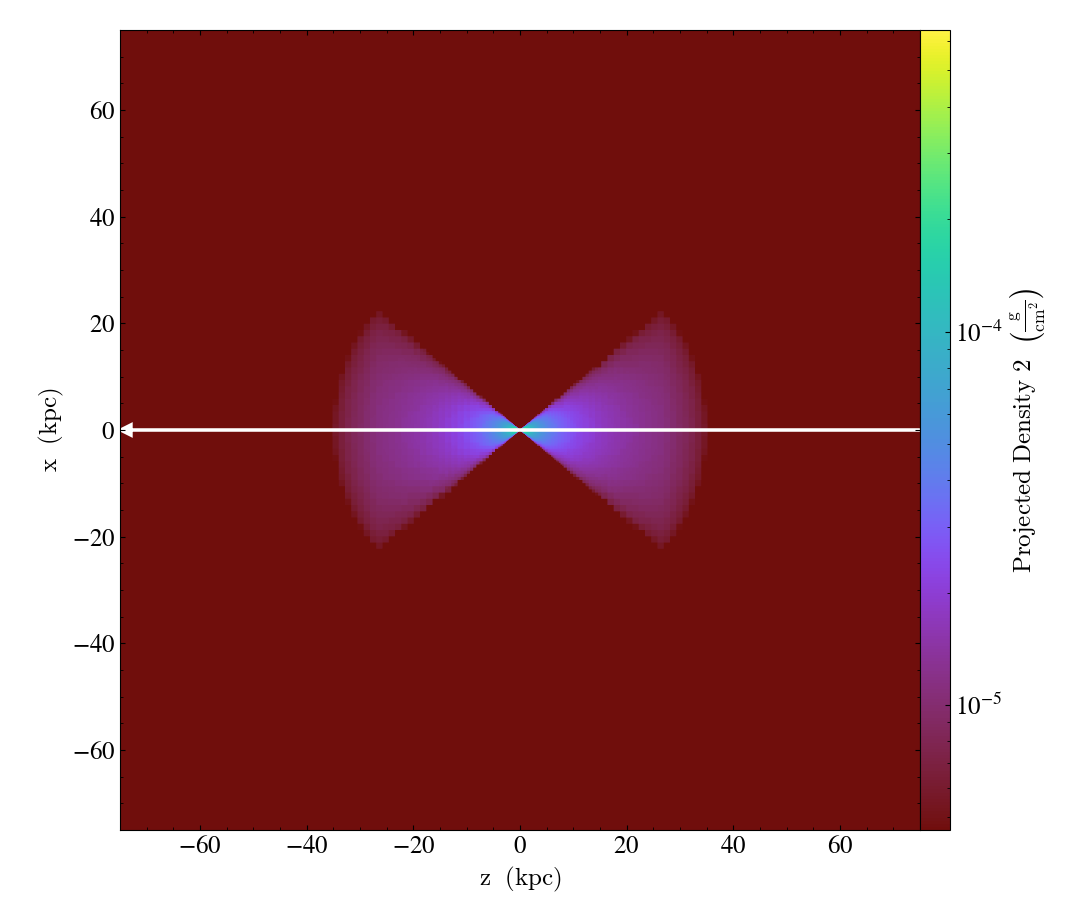

In [30]:
#Shows where the rays head towards
p = yt.ProjectionPlot(ds, 'y', 'density')
p.annotate_ray(ray, arrow=True)
p.show()

yt : [INFO     ] 2024-08-21 18:02:36,288 Projection completed
yt : [INFO     ] 2024-08-21 18:02:36,289 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-08-21 18:02:36,290 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-08-21 18:02:36,292 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-08-21 18:02:36,292 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-08-21 18:02:36,293 Making a fixed resolution buffer of (('gas', 'O_p5_number_density')) 800 by 800
yt : [INFO     ] 2024-08-21 18:02:36,698 Saving plot new_mu.png



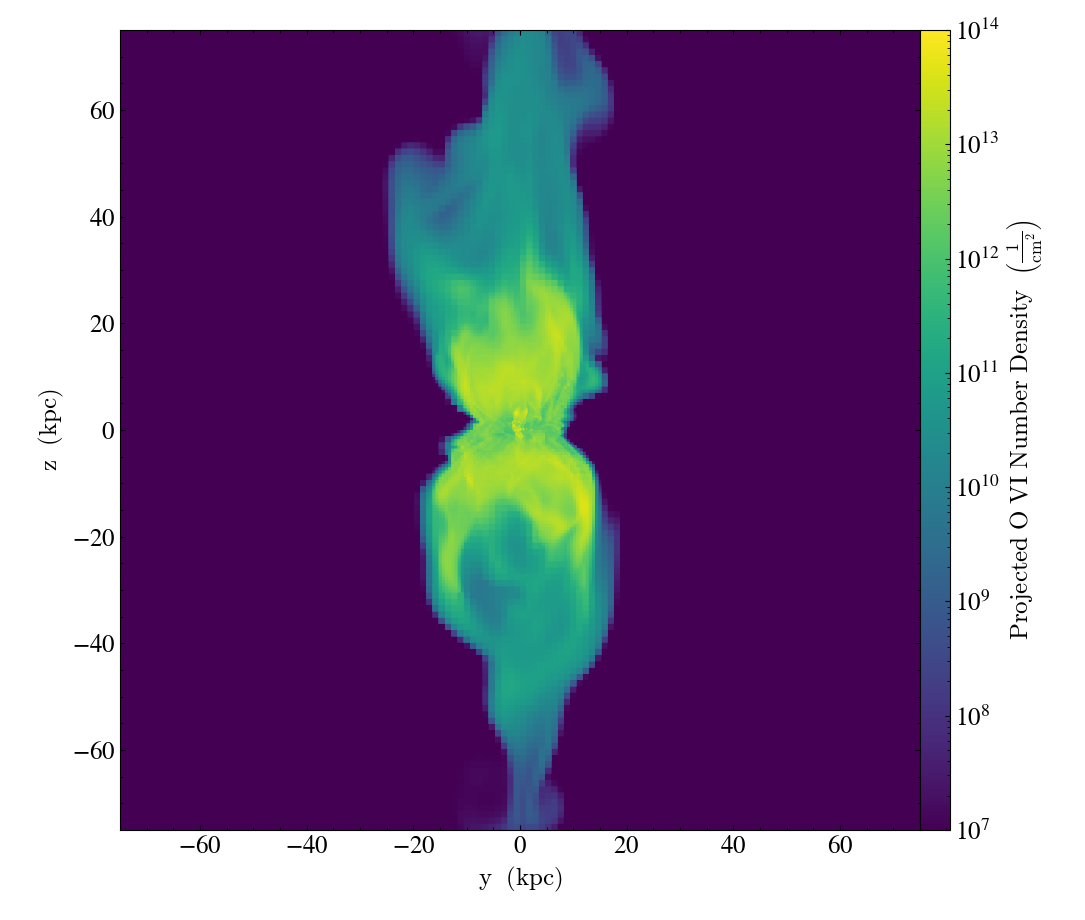

In [19]:
plot_Si = yt.ProjectionPlot(ds, 'x', 'O_p5_number_density')
plot_Si.zoom(1)
plot_Si.set_cmap('O_p5_number_density', 'viridis')
plot_Si.set_zlim('O_p5_number_density', 1e7, 1e14)
plot_Si.save('new_mu.png')
plot_Si.show()

# plot_Si = yt.ProjectionPlot(ds, 'z', 'O_p5_number_density')
# plot_Si.zoom(1)
# plot_Si.set_cmap('O_p5_number_density', 'viridis')
# plot_Si.set_zlim('O_p5_number_density', 1e7, 1e13)
# plot_Si.show()


#   Analysis: column density and spectrum

In [13]:
#Finds the column density, the order of magnitude looks about right
column_density_HI = ray.r[('gas', 'C_p3_number_density')] * ray.r[('gas', 'dl')]
print('Column Density = %g' % column_density_HI.sum())

Column Density = 2.5041e+13


In [8]:
print(ad)

YTRegion (ray.h5): , center=[2.31425819e+23 2.31425819e+23 2.31425819e+23] cm, left_edge=[0. 0. 0.] cm, right_edge=[4.62851637e+23 4.62851637e+23 4.62851637e+23] cm


In [ ]:
#saves the plots of each component, we can further specify like ['H I'] or ['H I 1216']
sg = trident.SpectrumGenerator(lambda_min='auto', lambda_max='auto', dlambda=0.01) #can plot in terms of the velocity shift
sg.make_spectrum(ray, lines=['H I 1216'])
sg.save_spectrum('Spectra/spec_H.h5')
sg.plot_spectrum('Spectra/spec_H.png')

sg = trident.SpectrumGenerator(lambda_min='auto', lambda_max='auto', dlambda=1, bin_space = 'velocity')
sg.make_spectrum(ray, lines=['C IV 1548'])
sg.save_spectrum('Spectra/spec_Cvel.h5')
sg.plot_spectrum('Spectra/spec_Cvel.png')

sg = trident.SpectrumGenerator(lambda_min='auto', lambda_max='auto', dlambda=0.01)
sg.make_spectrum(ray, lines=['C IV 1548', 'C IV 1551'])
sg.save_spectrum('Spectra/spec_C.h5')
sg.plot_spectrum('Spectra/spec_C.png')

sg = trident.SpectrumGenerator(lambda_min='auto', lambda_max='auto', dlambda=0.01)
sg.make_spectrum(ray, lines=['C II 1335'])
sg.save_spectrum('Spectra/spec_CII.h5')
sg.plot_spectrum('Spectra/spec_CII.png')

sg = trident.SpectrumGenerator(lambda_min='auto', lambda_max='auto', dlambda=0.01)
sg.make_spectrum(ray, lines=['O VI'])
sg.save_spectrum('Spectra/spec_OVI.h5')
sg.plot_spectrum('Spectra/spec_OVI.png')

yt : [INFO     ] 2024-07-29 19:05:09,852 Setting instrument to Custom
yt : [INFO     ] 2024-07-29 19:05:09,856 Creating spectrum
Adding line - Ly a [1215.670000 A]:   0%|          | 0/199 [00:00<?, ?it/s]

Adding line - Ly a [1215.670000 A]:  99%|█████████▉| 198/199 [00:00<00:00, 530.95it/s]
yt : [INFO     ] 2024-07-29 19:05:10,256 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2024-07-29 19:05:10,256 Writing spectrum to hdf5 file: Spectra/spec_H.h5.
yt : [INFO     ] 2024-07-29 19:05:10,271 Writing spectrum plot to png file: Spectra/spec_H.png
yt : [INFO     ] 2024-07-29 19:05:10,330 Setting instrument to Custom
yt : [INFO     ] 2024-07-29 19:05:10,334 Creating spectrum
yt : [INFO     ] 2024-07-29 19:05:10,335 Setting wavelength of velocity center to C IV 1548 line at z = 0.000: 1548.187 Å.
Adding line - C IV 1548 [1548.187000 A]:  99%|█████████▉| 198/199 [00:00<00:00, 3167.40it/s]
yt : [INFO     ] 2024-07-29 19:05:10,410 Writing spectrum to hdf5 file: Spectra/spec_Cvel.h5.
yt : [INFO     ] 2024-07-29 19:05:10,423 Writing spectrum plot to png file: Spectra/spec_Cvel.png
yt : [INFO     ] 2024-07-29 19:05:10,485 Setting instrument to Custom
yt : [IN

In [ ]:
sg = trident.SpectrumGenerator(lambda_min='auto', lambda_max='auto', dlambda=0.002)
sg.make_spectrum(ray, lines=['Si III 1206'])
sg.save_spectrum('Spectra/spec_SiIII.h5')
sg.plot_spectrum('Spectra/spec_SiIII.png')

sg = trident.SpectrumGenerator(lambda_min=1390, lambda_max=1404, dlambda=0.01)
sg.make_spectrum(ray, lines=['Si IV'])
sg.save_spectrum('Spectra/spec_SiIV1.h5')
sg.plot_spectrum('Spectra/spec_SiIV1.png')

sg = trident.SpectrumGenerator(lambda_min='auto', lambda_max='auto', dlambda=0.002)
sg.make_spectrum(ray, lines=['Si IV 1403'])
sg.save_spectrum('Spectra/spec_SiIV2.h5')
sg.plot_spectrum('Spectra/spec_SiIV2.png')

yt : [INFO     ] 2024-07-29 19:05:10,996 Setting instrument to Custom
yt : [INFO     ] 2024-07-29 19:05:11,001 Creating spectrum
Adding line - Si III 1206 [1206.500000 A]:   0%|          | 0/199 [00:00<?, ?it/s]

Adding line - Si III 1206 [1206.500000 A]:  99%|█████████▉| 198/199 [00:00<00:00, 5061.08it/s]
yt : [INFO     ] 2024-07-29 19:05:11,049 Writing spectrum to hdf5 file: Spectra/spec_SiIII.h5.
yt : [INFO     ] 2024-07-29 19:05:11,062 Writing spectrum plot to png file: Spectra/spec_SiIII.png
yt : [INFO     ] 2024-07-29 19:05:11,124 Setting instrument to Custom
yt : [INFO     ] 2024-07-29 19:05:11,131 Creating spectrum
yt : [INFO     ] 2024-07-29 19:05:11,137 3 out of 199 line components are unresolved.
Adding line - Si IV 1403 [1402.770000 A]:  99%|█████████▉| 198/199 [00:00<00:00, 11651.99it/s]
yt : [INFO     ] 2024-07-29 19:05:11,156 Writing spectrum to hdf5 file: Spectra/spec_SiIV1.h5.
yt : [INFO     ] 2024-07-29 19:05:11,192 Writing spectrum plot to png file: Spectra/spec_SiIV1.png
yt : [INFO     ] 2024-07-29 19:05:11,244 Setting instrument to Custom
yt : [INFO     ] 2024-07-29 19:05:11,248 Creating spectrum
Adding line - Si IV 1403 [1402.770000 A]:  99%|█████████▉| 198/199 [00:00<00:0

In [ ]:
#plot interesting metals
sg = trident.SpectrumGenerator(lambda_min='auto', lambda_max='auto', dlambda=0.002)
sg.make_spectrum(ray, lines=['Mg'])
sg.save_spectrum('Spectra/spec_Mg.h5')
sg.plot_spectrum('Spectra/spec_Mg.png')

yt : [INFO     ] 2024-07-29 19:05:11,358 Setting instrument to Custom
yt : [INFO     ] 2024-07-29 19:05:11,363 Creating spectrum
Adding line - Mg II 1240 [1240.394700 A]:  99%|█████████▉| 198/199 [00:00<00:00, 9796.42it/s]


Adding line - Mg X 610 [609.793000 A]:  99%|█████████▉| 198/199 [00:00<00:00, 3965.53it/s]
yt : [INFO     ] 2024-07-29 19:05:11,524 Writing spectrum to hdf5 file: Spectra/spec_Mg.h5.
yt : [INFO     ] 2024-07-29 19:05:11,571 Writing spectrum plot to png file: Spectra/spec_Mg.png


In [ ]:
#saves the whole spectrum showing all peaks with the "auto" keywords
sg = trident.SpectrumGenerator(lambda_min=600, lambda_max=1600, dlambda=0.1)
sg.make_spectrum(ray, lines=line_list)
sg.save_spectrum('Spectra/spec_raw.h5')
sg.plot_spectrum('Spectra/spec_raw.png')

yt : [INFO     ] 2024-07-29 19:22:16,558 Setting instrument to Custom
yt : [INFO     ] 2024-07-29 19:22:16,568 Creating C_p0_number_density from ray's fields.
yt : [INFO     ] 2024-07-29 19:22:16,603 Creating Si_p1_number_density from ray's fields.
yt : [INFO     ] 2024-07-29 19:22:16,652 Creating Si_p11_number_density from ray's fields.
yt : [INFO     ] 2024-07-29 19:22:16,692 Creating spectrum
yt : [INFO     ] 2024-07-29 19:22:16,699 115 out of 188 line components are unresolved.
Adding line - Ly a [1215.670000 A]:  99%|█████████▉| 187/188 [00:00<00:00, 240.44it/s]
yt : [INFO     ] 2024-07-29 19:22:17,479 116 out of 188 line components are unresolved.
Adding line - Ly 39 [912.323663 A]:  99%|█████████▉| 187/188 [00:00<00:00, 4466.60it/s]
yt : [INFO     ] 2024-07-29 19:22:19,624 120 out of 188 line components are unresolved.
Adding line - C I 1329 [1328.834000 A]:  99%|█████████▉| 187/188 [00:00<00:00, 5650.05it/s]
yt : [INFO     ] 2024-07-29 19:22:19,724 121 out of 188 line component

In [ ]:
#We can select the cold regions and create a spectrum there with the yt command
all_data = ray.all_data()
cold_gas = ray.cut_region(all_data, 'obj["gas", "temperature"] < 25000')

#       If no lines are present then original file will be unaltered
sgc = trident.SpectrumGenerator(lambda_min=600, lambda_max=1600, dlambda=0.001)
sgc.make_spectrum(cold_gas, lines=line_list)
sgc.save_spectrum('Spectra/spec_cold.h5')
sgc.plot_spectrum('Spectra/spec_cold.png')

yt : [INFO     ] 2024-07-29 19:07:03,921 Setting instrument to Custom
yt : [INFO     ] 2024-07-29 19:07:03,944 Creating spectrum
Adding line - Ly a [1215.670000 A]:   0%|          | 0/13 [00:00<?, ?it/s]

Adding line - N IV 765 [765.147000 A]:  92%|█████████▏| 12/13 [00:00<00:00, 5464.89it/s]
yt : [INFO     ] 2024-07-29 19:07:07,531 Not adding line N V 1243: insufficient column density
yt : [INFO     ] 2024-07-29 19:07:07,531 Not adding line N V 1239: insufficient column density
Adding line - O IV 553 [553.329000 A]:  92%|█████████▏| 12/13 [00:00<00:00, 15114.61it/s]
yt : [INFO     ] 2024-07-29 19:07:08,003 Not adding line O V 630: insufficient column density
yt : [INFO     ] 2024-07-29 19:07:08,004 Not adding line O VI 1038: insufficient column density
yt : [INFO     ] 2024-07-29 19:07:08,005 Not adding line O VI 1032: insufficient column density
Adding line - Mg II 1240 [1239.925300 A]:  92%|█████████▏| 12/13 [00:00<00:00, 1161.67it/s]
yt : [INFO     ] 2024-07-29 19:07:08,042 Not adding line Mg X 625: insufficient column density
yt : [INFO     ] 2024-07-29 19:07:08,042 Not adding line Mg X 610: insufficient column density
Adding line - Si IV 1403 [1402.770000 A]:  92%|█████████▏| 12/1

In [ ]:
#Overlap the cold and normal spectrum by creating two lists (cold_spectrum and all_spectrum) from the same spectrum object, with different selected dataset
sgc.make_spectrum(cold_gas, lines=line_list)
cold_spectrum = sgc.flux_field[:]
sgc.make_spectrum(all_data, lines=line_list)
all_spectrum = sgc.flux_field[:]

fig = trident.plot_spectrum(sgc.lambda_field, [all_spectrum, cold_spectrum], label=['all gas', 'cold gas'], stagger=None)
fig.supxlabel('Wavelength (Angstroms)')
fig.savefig('overlap.png')

f = h5py.File('Spectra/spec_raw.h5')
wavelength = f["wavelength"][:]
flux = f['flux'][:]
f.close()

f = h5py.File('Spectra/spec_cold.h5')
wavelengthC = f["wavelength"][:]
fluxC = f['flux'][:]
f.close()


yt : [INFO     ] 2024-07-29 19:07:14,882 Creating spectrum
Adding line - Ly a [1215.670000 A]:   0%|          | 0/13 [00:00<?, ?it/s]

Adding line - N IV 765 [765.147000 A]:  92%|█████████▏| 12/13 [00:00<00:00, 7784.05it/s]
yt : [INFO     ] 2024-07-29 19:07:18,362 Not adding line N V 1243: insufficient column density
yt : [INFO     ] 2024-07-29 19:07:18,363 Not adding line N V 1239: insufficient column density
Adding line - O IV 553 [553.329000 A]:  92%|█████████▏| 12/13 [00:00<00:00, 13861.65it/s]
yt : [INFO     ] 2024-07-29 19:07:18,791 Not adding line O V 630: insufficient column density
yt : [INFO     ] 2024-07-29 19:07:18,792 Not adding line O VI 1038: insufficient column density
yt : [INFO     ] 2024-07-29 19:07:18,792 Not adding line O VI 1032: insufficient column density
Adding line - Mg II 1240 [1239.925300 A]:  92%|█████████▏| 12/13 [00:00<00:00, 1233.44it/s]
yt : [INFO     ] 2024-07-29 19:07:18,824 Not adding line Mg X 625: insufficient column density
yt : [INFO     ] 2024-07-29 19:07:18,825 Not adding line Mg X 610: insufficient column density
Adding line - Si IV 1403 [1402.770000 A]:  92%|█████████▏| 12/1

KeyboardInterrupt: 

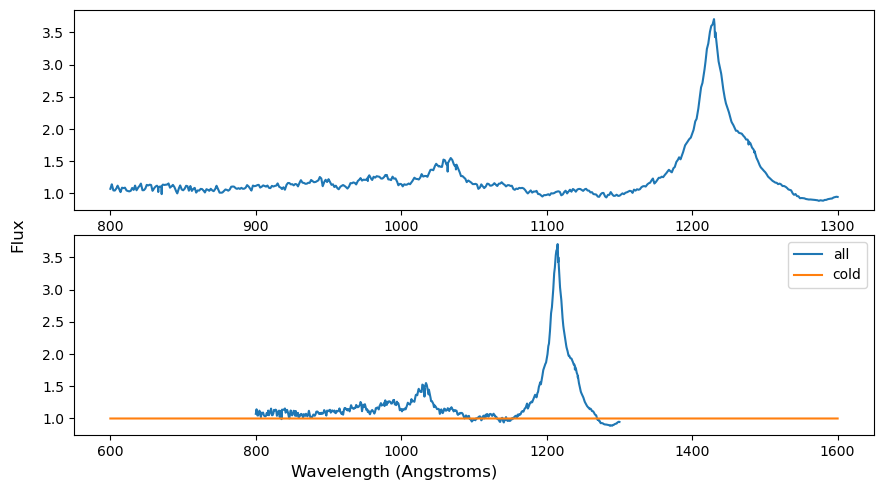

In [ ]:
#Plotting the overlap
fig = plt.figure(figsize = [8, 5])
fig.supylabel('Flux')
fig.supxlabel('Wavelength (Angstroms)')
ax = fig.add_axes((0.1, 0.1, 1, 0.4))
l1 = ax.plot(wavelength, flux, label = 'all')
l2 = ax.plot(wavelengthC, fluxC, label = 'cold')
ax.legend()
ax2 = fig.add_axes((0.1, 0.55, 1, 0.4))
ax2.plot(wavelength, flux)
fig.savefig('overlaps')

In [ ]:
# Adding some background noise
sg = trident.SpectrumGenerator(lambda_min=600, lambda_max=1800, dlambda=0.1)
sg.make_spectrum(ray, lines=line_list)

sg.add_qso_spectrum()
#sg.add_milky_way_foreground()
sg.add_gaussian_noise(30)

sg.save_spectrum('Spectra/spec_raw_noise.txt')
sg.plot_spectrum('Spectra/spec_raw_noise.png')

yt : [INFO     ] 2024-07-26 17:22:42,931 Setting instrument to Custom
yt : [INFO     ] 2024-07-26 17:22:42,972 Creating C_p0_number_density from ray's fields.
yt : [INFO     ] 2024-07-26 17:22:43,009 Creating Si_p1_number_density from ray's fields.
yt : [INFO     ] 2024-07-26 17:22:43,022 Creating Si_p11_number_density from ray's fields.
yt : [INFO     ] 2024-07-26 17:22:43,050 Creating spectrum
Adding line - Ly 39 [912.323663 A]:  99%|█████████▉| 141/142 [00:00<00:00, 5100.10it/s]
yt : [INFO     ] 2024-07-26 17:22:44,306 6 out of 142 line components are unresolved.
Adding line - C I 1657 [1656.929000 A]:  99%|█████████▉| 141/142 [00:00<00:00, 27455.75it/s]
yt : [INFO     ] 2024-07-26 17:22:44,321 8 out of 142 line components are unresolved.
Adding line - C I 1560 [1560.309000 A]:  99%|█████████▉| 141/142 [00:00<00:00, 33224.54it/s]
yt : [INFO     ] 2024-07-26 17:22:44,334 10 out of 142 line components are unresolved.
Adding line - C I 1277 [1277.245000 A]:  99%|█████████▉| 141/142 [00

# Using the COS preset

In [ ]:
sgCos = trident.SpectrumGenerator('COS-G130M')
sgCos.make_spectrum(ray, lines=line_list)
sgCos.apply_lsf()
sgCos.save_spectrum('Spectra/COSlsf.h5')
sgCos.plot_spectrum('Spectra/COSlsf.png')

yt : [INFO     ] 2024-07-26 17:22:46,171 Setting instrument to COS-G130M
yt : [INFO     ] 2024-07-26 17:22:46,210 Creating spectrum
Adding line - Si XII 499 [499.406000 A]:  99%|█████████▉| 141/142 [00:00<00:00, 6484.47it/s]
yt : [INFO     ] 2024-07-26 17:22:48,653 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2024-07-26 17:22:48,656 Applying default line spread function for COS-G130M.
yt : [INFO     ] 2024-07-26 17:22:48,662 Writing spectrum to hdf5 file: Spectra/COSlsf.h5.
yt : [INFO     ] 2024-07-26 17:22:48,717 Writing spectrum plot to png file: Spectra/COSlsf.png


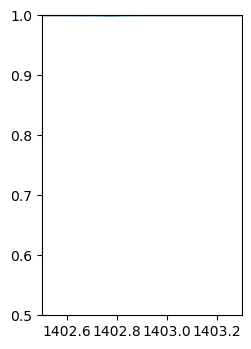

In [ ]:
f = h5py.File('Spectra/COSlsf.h5')
wavelength = f["wavelength"][:]
flux = f['flux'][:]
f.close()

fig = plt.figure(figsize = (2, 3))
ax = fig.add_axes((0, 0, 1, 1))
ax.plot(wavelength, flux)
ax.set_xlim(1402.5, 1403.3)
ax.set_ylim(0.5, 1)
fig.savefig('LSF.png')

#   Spectrum Fitting

In [25]:
#Saving the spectrum of interest to a .h5 file
#sg = trident.SpectrumGenerator(lambda_min=1548, lambda_max=1552, dlambda=0.002)
sg = trident.SpectrumGenerator(lambda_min=800, lambda_max=1600, dlambda=0.02)
#sg = trident.SpectrumGenerator('COS')
#sg.make_spectrum(ray, lines=['H I 1025.728', 'H I 973'])
#sg.make_spectrum(ray, lines=['H I 1216', 'C IV 1548', 'C IV 1551', 'O VI 1032'])
sg.make_spectrum(ray, lines='all')
#sg.make_spectrum(ray, lines=['O VI 1032', 'H I'])
#sg.make_spectrum(ray, lines=['C IV 1548', 'C IV 1551'])
#sg.add_qso_spectrum()
#sg.add_gaussian_noise(20)
sg.save_spectrum('Spectra/spec_CH.h5')
sg.plot_spectrum('Spectra/spec_CH.png')

yt : [INFO     ] 2024-08-05 20:12:29,431 Setting instrument to Custom
yt : [INFO     ] 2024-08-05 20:12:29,437 Using all 213 available lines in 'lines.txt'.
yt : [INFO     ] 2024-08-05 20:12:29,441 Creating C_p0_number_density from ray's fields.
yt : [INFO     ] 2024-08-05 20:12:29,457 Creating Ne_p4_number_density from ray's fields.
yt : [INFO     ] 2024-08-05 20:12:29,462 Creating Ne_p5_number_density from ray's fields.
yt : [INFO     ] 2024-08-05 20:12:29,466 Creating Ne_p6_number_density from ray's fields.
yt : [INFO     ] 2024-08-05 20:12:29,470 Creating Ne_p7_number_density from ray's fields.
yt : [INFO     ] 2024-08-05 20:12:29,476 Creating Na_p8_number_density from ray's fields.
yt : [INFO     ] 2024-08-05 20:12:29,481 Creating Al_p1_number_density from ray's fields.
yt : [INFO     ] 2024-08-05 20:12:29,485 Creating Al_p2_number_density from ray's fields.
yt : [INFO     ] 2024-08-05 20:12:29,489 Creating Si_p1_number_density from ray's fields.
yt : [INFO     ] 2024-08-05 20:12:

In [20]:
print(sg.lambda_field.value)

[ 800.    800.02  800.04 ... 1599.96 1599.98 1600.  ]


In [21]:
#We can make a plot directly with trident.plot_spectrum, though it does not return a plt.figure object so idk how to plot directly
spec = trident.load_spectrum('Spectra/spec_C.h5')
fig = trident.plot_spectrum(spec.lambda_field, spec.flux_field)


yt : [INFO     ] 2024-08-05 15:44:01,017 Setting instrument to Custom
yt : [INFO     ] 2024-08-05 15:44:01,030 Writing spectrum plot to png file: spectrum.png


In [10]:
#Find oscillator strength
e = 1.60217663e-19
ep = 8.85418782e-12     #permitivity of vacuum
m_e = 9.1093837e-31
c = 299792458

def A_to_f_conv(gamma, Lambda, g2, g1):
    '''
    Function to convert between the decay rate and oscillator strength

    Parameters:
        gamma (float): the decay rate
        lambda (float): wavelength corresponding to this transition
        g2 (int): the degeneracy of the higher energy state
        g1 (int): the degeneracy of the lower energy state

    returns:
        float : the oscillator strength

    '''
    v=c/(Lambda*1e-10)
    print(v)
    f = g2/g1 * (ep*m_e*c*c*c)/(2*np.pi*v*v*e*e)*gamma
    return f

In [1]:
# Loading the file created by SpectrumGenerator
f = h5py.File('Spectra/spec_CH.h5')
wavelength = f["wavelength"][:]
flux = f['flux'][:]
f.close()


fig = plt.figure(figsize = [8, 2])
ax = fig.add_axes((0, 0, 1, 1))
ax.plot(wavelength, flux)
ax.set_xlim(1020, 1040)
ax.vlines([1031.88, 1037.6], 0, 2, color = 'red')
#ax.set_ylim(0, 1.2)
fig.show()

NameError: name 'h5py' is not defined

In [55]:
#Specifying the relevant parameters for the fit of different lines
H_I_alpha_parameters = {'name':'H I 1216',
        'f': [4.1641e-01],
        'Gamma':[4.6986e+08],
        'wavelength':[1216],
        'numLines':1,
        'maxN': 1E22, 'minN':1E6,
        'maxb': 5000, 'minb':1,
        'maxz': 6, 'minz':0,
        'init_b':300,
        'init_N':1E14}

H_I_1025_parameters = {'name':'H I 1025',
        'f': [4.1641e-01],
        'Gamma':[4.6986e+08],
        'wavelength':[1025],
        'numLines':1,
        'maxN': 1E22, 'minN':1E6,
        'maxb': 5000, 'minb':1,
        'maxz': 6, 'minz':0,
        'init_b':300,
        'init_N':1E14}

H_I_973_parameters = {'name':'H I 973',
        'f': [2.9006e-02],
        'Gamma':[1.2785e+07],
        'wavelength':[972.517],
        'numLines':1,
        'maxN': 1E22, 'minN':1E11,
        'maxb': 300, 'minb':1,
        'maxz': 6, 'minz':0,
        'init_b':30,
        'init_N':1E14}

C_IV_1548_parameters = {'name':'C IV 1548',
        'f': [1.9e-1],
        'Gamma':[2.65e+08],
        'wavelength':[1548],
        'numLines':1,
        'maxN': 1E14, 'minN':1E12,
        'maxb': 10, 'minb':1,
        'maxz': 6, 'minz':0,
        'init_b':5,
        'init_N':1E14}

C_IV_1555_parameters = {'name':'C IV 1555',
        'f': [9.52e-02],
        'Gamma':[2.64e+08],
        'wavelength':[1555],
        'numLines':1,
        'maxN': 1E18, 'minN':1E6,
        'maxb': 100, 'minb':1,
        'maxz': 6, 'minz':0,
        'init_b':30,
        'init_N':1E14}

O_VI_1032_parameters = {'name':'O VI 1032',
        'f': [1.33e-01],
        'Gamma':[4.16e+08],
        'wavelength':[1032],
        'numLines':1,
        'maxN': 1E15, 'minN':1E10,
        'maxb': 50, 'minb':1,
        'maxz': 6, 'minz':0,
        'init_b':40,
        'init_N':1E13}

O_VI_1038_parameters = {'name':'O VI 1038',
        'f': [6.60e-02],
        'Gamma':[4.09e+08],
        'wavelength':[1038],
        'numLines':1,
        'maxN': 1E15, 'minN':1E10,
        'maxb': 100, 'minb':1,
        'maxz': 6, 'minz':0,
        'init_b':30,
        'init_N':1E14}

Mg_II_1240_parameters = {'name':'Mg II 1240',
        'f': [6.21e-04],
        'Gamma':[1.35e+06],
        'wavelength':[1240],
        'numLines':1,
        'maxN': 1E22, 'minN':1E6,
        'maxb': 6000, 'minb':1,
        'maxz': 6, 'minz':0,
        'init_b':30,
        'init_N':1E14}

speciesDicts = {'C IV 1548': C_IV_1548_parameters,
                'C IV 1555': C_IV_1555_parameters,
                'H I 1216': H_I_alpha_parameters,
                'H I 1025': H_I_1025_parameters,
                'H I 973': H_I_973_parameters,
                'O VI 1032': O_VI_1032_parameters,
                'O VI 1038': O_VI_1038_parameters,
                'Mg II 1240': Mg_II_1240_parameters
                }


In [56]:
#specifying what lines to be fitted and then fitting it
orderFits = ['O VI 1038']

upper = np.searchsorted(wavelength, 1040)
lower = np.searchsorted(wavelength, 1036)

fitted_lines, fitted_flux, cBounds = generate_total_fit(wavelength[lower:upper], flux[lower:upper], orderFits, speciesDicts, complexLim = 0.99)
print(fitted_lines)

#print(wavelength[4164])

{'O VI 1038': {'N': array([], dtype=float64), 'b': array([], dtype=float64), 'z': array([], dtype=float64), 'group#': array([], dtype=float64)}}


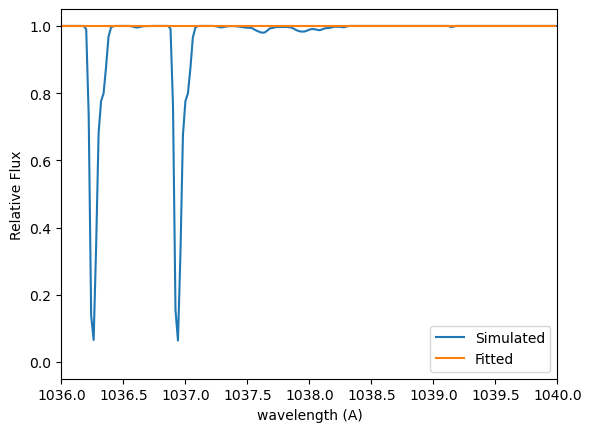

In [58]:
plt.plot(wavelength, flux)
plt.plot(wavelength[lower:upper], fitted_flux)
#plt.plot(wavelength, fitted_flux2)
#plt.vlines(1548.187, 0, 1)
#plt.hlines(0.87, 1030, 1040, 'r')
plt.xlim(1036, 1040)
plt.xlabel('wavelength (A)')
plt.ylabel('Relative Flux')
plt.legend(('Simulated', 'Fitted'))
plt.show()

ValueError: x and y must have same first dimension, but have shapes (40000,) and (499,)

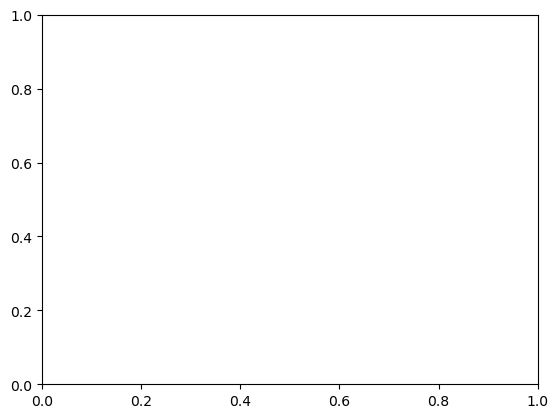

In [17]:
#Estimate the equivalent width
flux_inver = 1-fitted_flux
a = 0
b = -1
wl_for_W = wavelength[a:b]
flux_for_W = flux_inver[a:b]

plt.plot(wl_for_W, flux_for_W)

dA = (wl_for_W[1] - wl_for_W[0])*flux_for_W

W = np.sum(dA)
print('equivalent width = {num:.{dig}f} A'.format(num=W, dig = 4))

# Testing the fitting.py

In [22]:
sgb = trident.SpectrumGenerator(lambda_min=800, lambda_max=1600, dlambda=0.02)
sgb.make_spectrum(ray, lines = [])
sgb.add_qso_spectrum()
sgb.save_spectrum('Spectra/background.h5')

yt : [INFO     ] 2024-08-05 15:44:01,101 Setting instrument to Custom
yt : [INFO     ] 2024-08-05 15:44:01,107 Creating spectrum
yt : [INFO     ] 2024-08-05 15:44:01,119 Writing spectrum to hdf5 file: Spectra/background.h5.


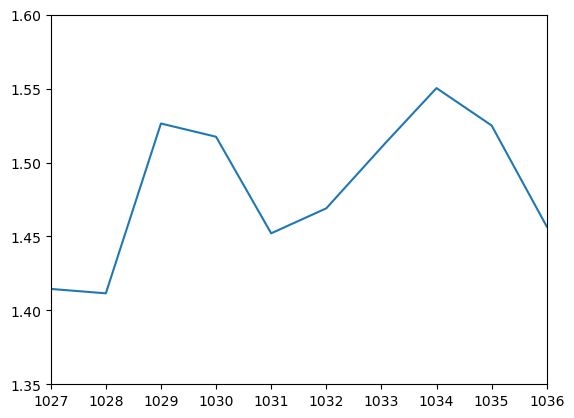

In [23]:
f = h5py.File('Spectra/background.h5')
wavelength_background = f["wavelength"][:]
flux_background = f["flux"][:]
f.close()

plt.plot(wavelength_background, flux_background)
plt.xlim(1027, 1036)
plt.ylim(1.35, 1.6)
plt.show()

(1545.0, 1560.0)

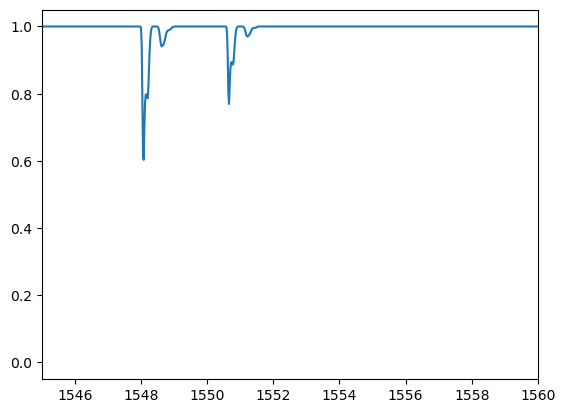

In [8]:
import matplotlib.pyplot as plt
plt.plot(wavelength, flux)
plt.xlim(1545, 1560)

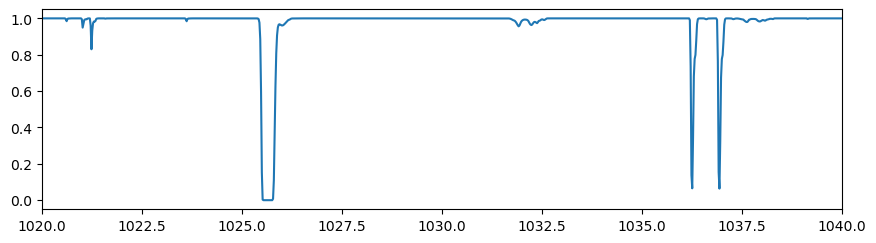

Mg II 1240.6
22130 21930
----------


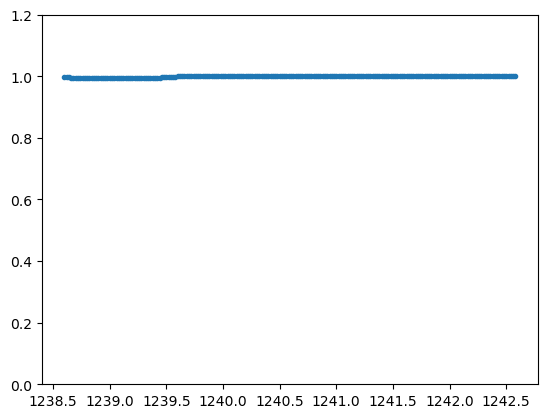

----------
CUBIC


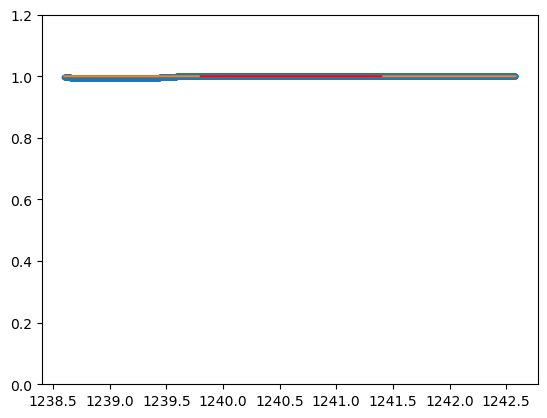

CUBIC
OKOKOKOKOK


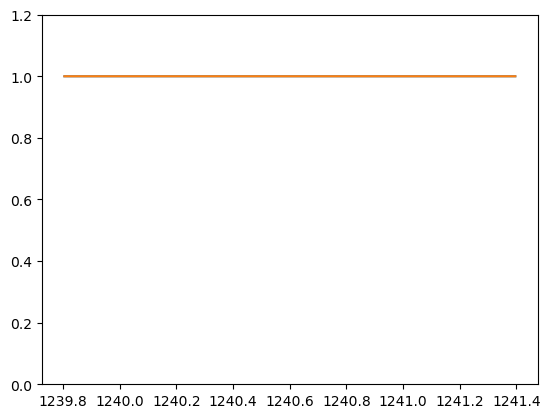

OKOKOKOKOK


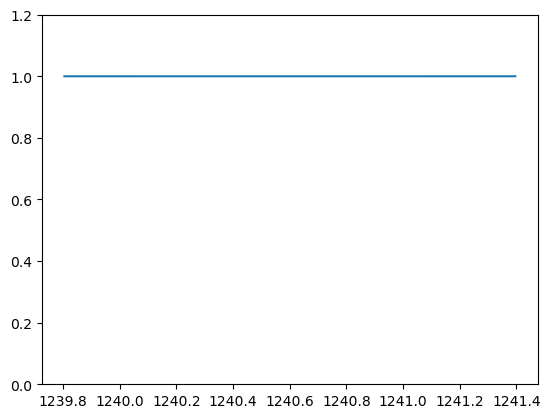

#########
21981 22001 0


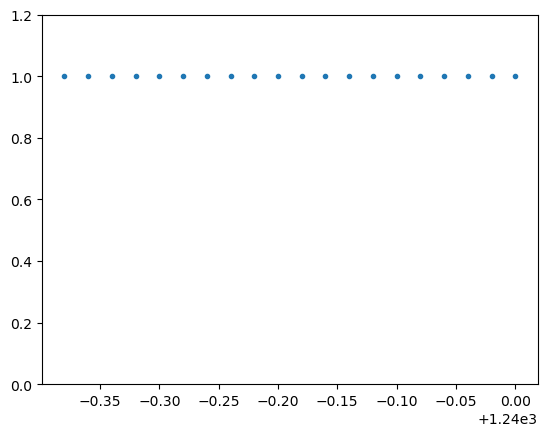

#########
1239.62 1240.02
*********


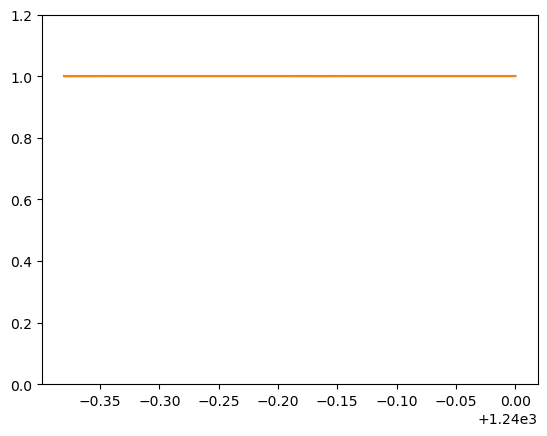

*********
{'Mg II 1240.6': {'N': array([], dtype=float64), 'b': array([], dtype=float64), 'z': array([], dtype=float64), 'group#': array([], dtype=float64)}}


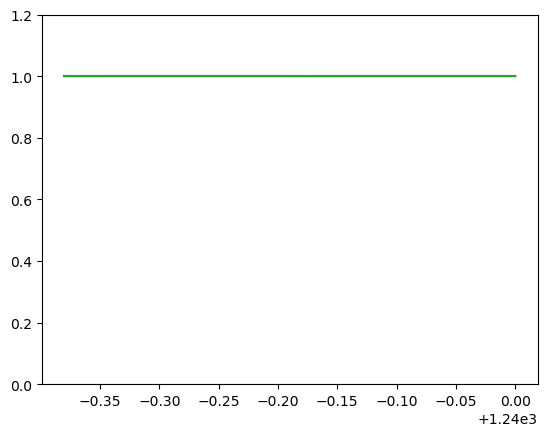

(0.91, 0.98)

In [1]:
import h5py
import numpy as np
from fitting import fitting
f = h5py.File('Spectra/spec_CH.h5')
wavelength = f["wavelength"][:]
flux = f['flux'][:]
f.close()


background = np.ones(len(flux))
fig, axO, ew_fit, ew_raw = fitting(wavelength, flux, ['Mg II 1240.6'], bg=background)
axO.set_xlim(1025, 1033)
axO.set_ylim(0.91, 0.98)

In [2]:
print(ew_fit)
print(ew_raw)

{'Mg II 1240.6': 0.0}
{'Mg II 1240.6': -2.4448854311260837e-05}


(1200.0, 1230.0)

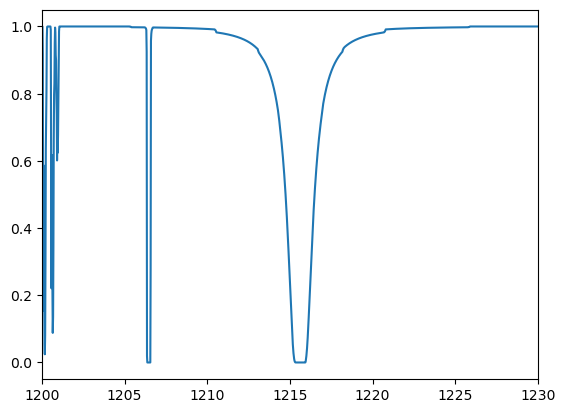

In [21]:
plt.plot(wavelength, flux)
plt.xlim(1200, 1230)